In [3]:
import matplotlib.pyplot as plt 
import numpy as np 
import torch 
from fitter.corr_func_2 import C_NG_to_C_G,diagnose_cl_G

mock_id       = 44 
N_bins        = 4  
N             = '3'
kappa_map     = np.load('/home/ivanespinoza/Extended-Lognormal/kappa_map_GWSt.npy')
fitted_params = np.load('/home/ivanespinoza/Extended-Lognormal/fitter_params.npy')
#fitted_params = np.load('/home/ivanespinoza/Extended-Lognormal/optimized_fitted_params.npy').reshape(4,3)
idx          ,= np.where(np.load('/spiff/ivanespinoza/weak_lensing_data_emulator_data/simulations_run/GWst_good_mock_id_updated.npy') == mock_id)
_,cl          = torch.load('/spiff/ivanespinoza/weak_lensing_data_emulator_data/simulations_run/biased_ccl_cl_good_Cosmo.pt')
cl_NG         = cl[idx].numpy()[0]
n_cores       = 16 #or use -1 for all cores


In [4]:
import time

start = time.time()
cl_G = C_NG_to_C_G(cl_NG, fitted_params, N_bins, N, quad_order=2,xig_grid_size=100, n_jobs=n_cores)
end = time.time()
print(f"Execution time: {end - start:.2f} seconds")
diagnose_cl_G(cl_G)

Execution time: 7.95 seconds
✓ All matrices are positive definite!
Minimum eigenvalue across all l: 1.000000e-20


In [5]:
from fitter.mocker import get_y_maps,get_kappa,get_kappa_pixwin,generate_xlm
from scipy.interpolate import interp1d
import healpy as hp 

np.random.seed(42)
Nside = 256 
gen_lmax = 3*Nside-1
lmax = 2*Nside
ell_pixwin, _ = hp.Alm.getlm(lmax)
pixwin = np.load('/spiff/ivanespinoza/weak_lensing_data_emulator_data/simulations_run/pixwin/pixwin_256.npy')
pixwin_interp          = interp1d(np.arange(len(pixwin)), pixwin)
pixwin_ell_filter      = pixwin_interp(ell_pixwin)
xlm,_ = generate_xlm(Nside,gen_lmax)
y_maps, _         = get_y_maps(cl_G, Nside, N_bins, gen_lmax, xlm)
kappa       = get_kappa(y_maps, N_bins, N, fitted_params)  
#kappa = get_kappa_pixwin(y_maps,N_bins,N,fitted_params,Nside,pixwin_ell_filter)

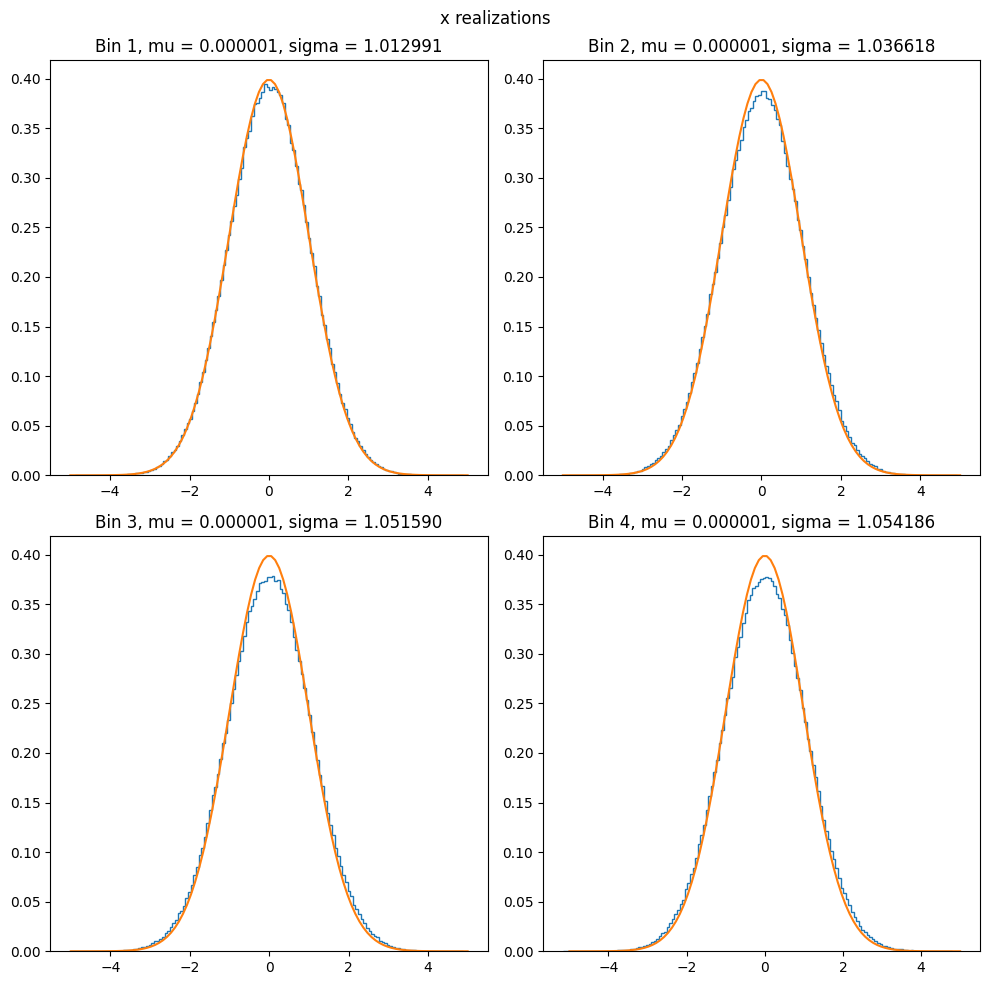

In [6]:
gauss = lambda x: np.exp(-0.5*x**2)/np.sqrt(2*np.pi)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()
x_vals = np.linspace(-5,5,100)
y_vals = gauss(x_vals)
for i in range(N_bins):
    mean_i = np.mean(y_maps[i])
    std_i = np.std(y_maps[i])
    axes[i].hist(y_maps[i],density=True,bins=150,histtype='step')
    axes[i].plot(x_vals,y_vals)
    axes[i].set_title(f'Bin {i+1}, mu = {mean_i:.6f}, sigma = {std_i:.6f}')
plt.suptitle('x realizations')
plt.tight_layout()
plt.show()

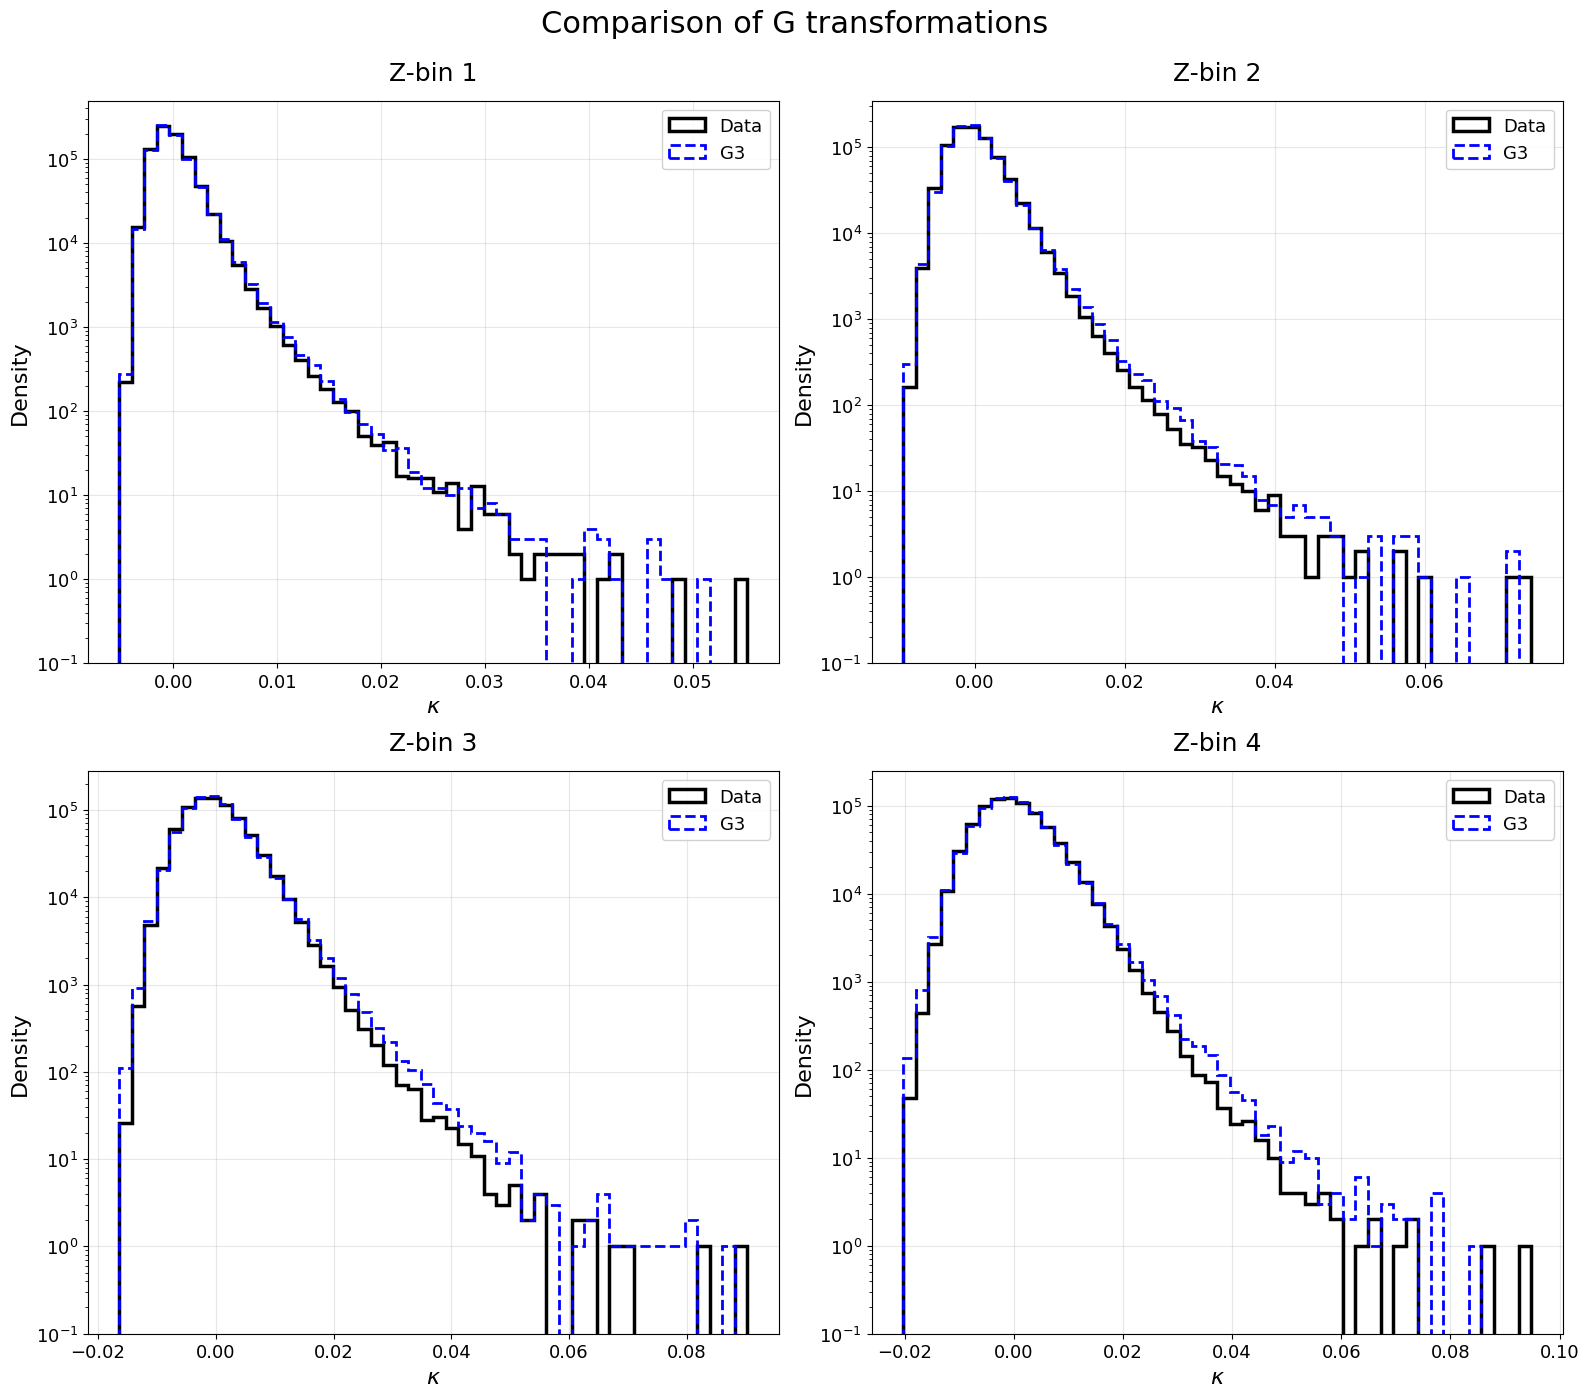

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()
for i in range(N_bins):
    ax = axes[i]
    counts, bins, _ = ax.hist(kappa_map[i], bins=50, histtype='step',
                              linewidth=2.5, label='Data', color='black')
    max_count = np.max(counts[counts > 0])
    y_upper = max_count * 2
    ax.hist(kappa[i], bins=bins, histtype='step',
        linewidth=2, label=f'G{N}', color='blue',
        linestyle='dashed')
    ax.set_yscale('log')
    ax.set_ylim(1e-1, y_upper)
    ax.set_xlabel(r'$\kappa$', fontsize=16)
    ax.set_ylabel('Density', fontsize=16)
    ax.set_title(f'Z-bin {i+1}', fontsize=18, pad=15)
    ax.legend(fontsize=13, loc='upper right', framealpha=0.9)
    ax.grid(alpha=0.3)
    ax.tick_params(labelsize=13)

fig.suptitle('Comparison of G transformations', fontsize=22, y=0.995)
plt.tight_layout()
plt.show()

In [8]:
ell_arr = np.arange(gen_lmax + 1)  # Should go up to gen_lmax, not 768
cl_kappa = np.zeros_like(cl_NG)

y_maps,_ = get_y_maps(cl_G,Nside,N_bins,gen_lmax)
kappa = get_kappa(y_maps,N_bins,N,fitted_params)
for i in range(N_bins):    
    for j in range(i+1):
        cl_ij = hp.anafast(kappa[i], kappa[j], lmax=gen_lmax)
        cl_kappa[i,j] = cl_ij
        cl_kappa[j,i] = cl_ij

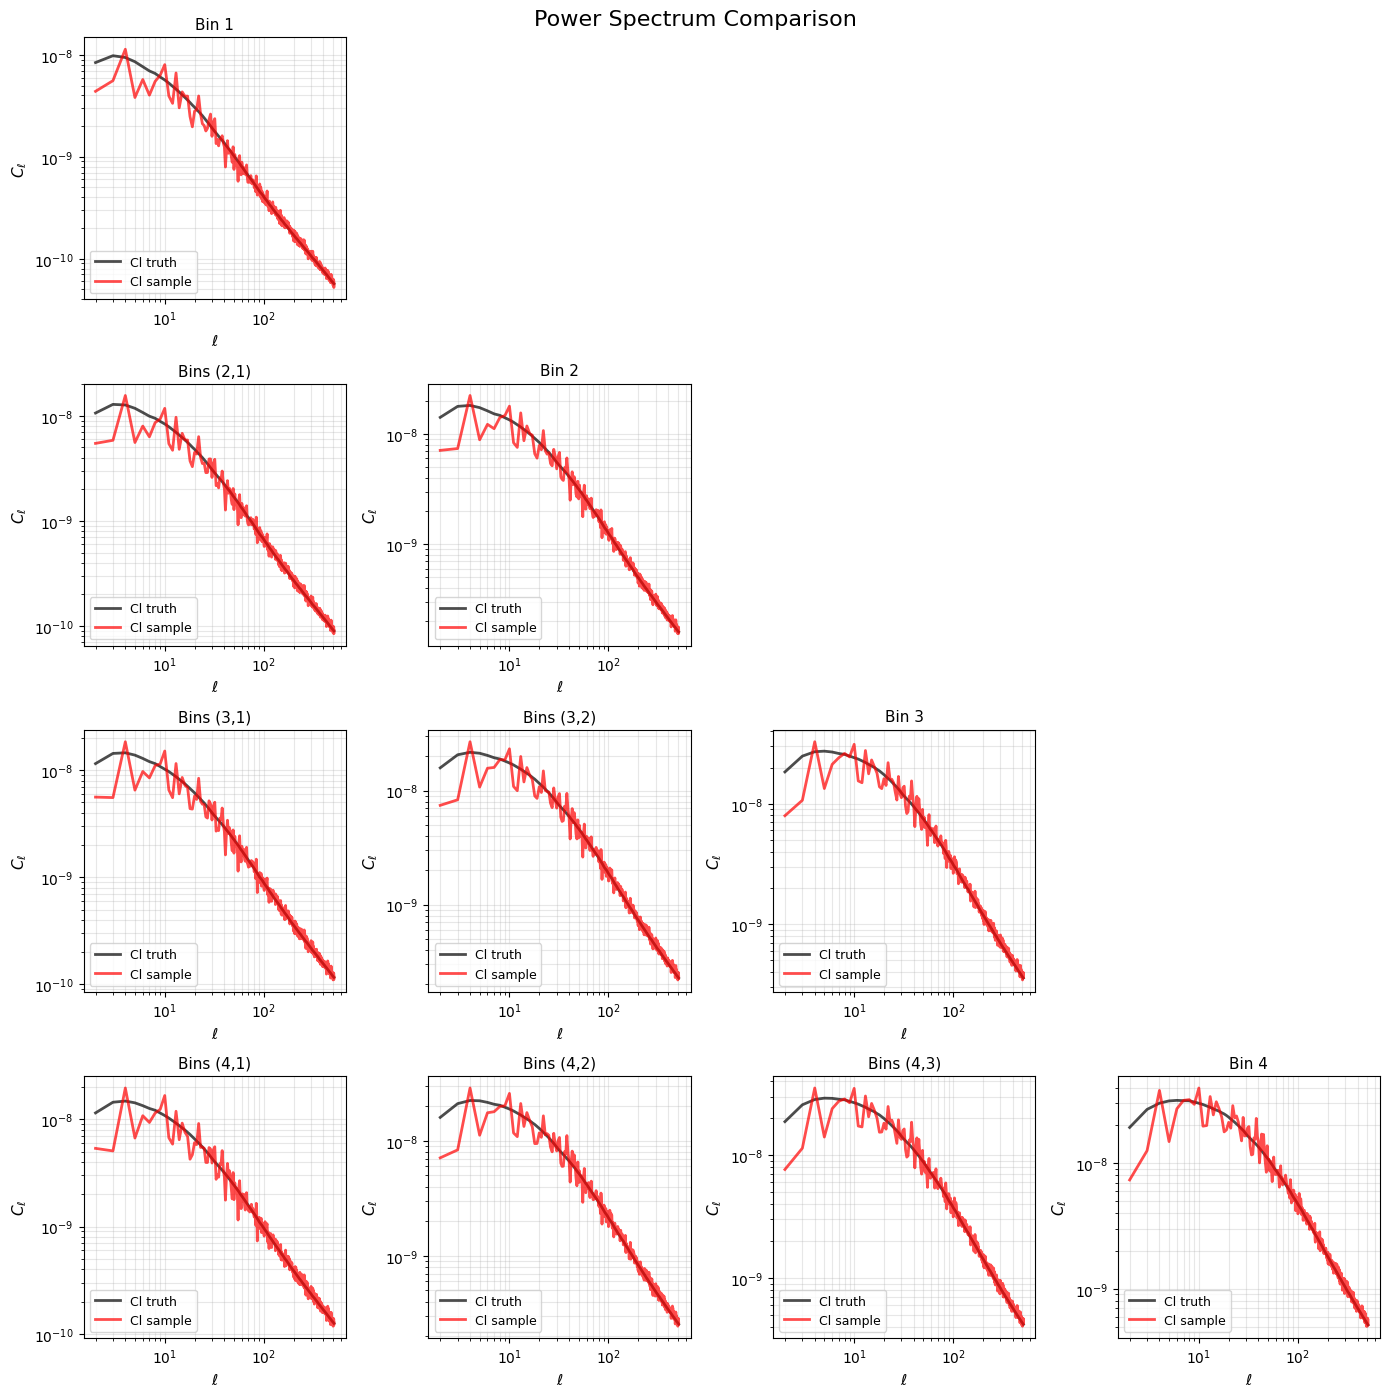

In [9]:
import matplotlib.pyplot as plt
def plot_cl_corner_separate_axes(cl_NG, cl_kappa, N_bins, ell_arr):
    """
    Create corner plot with separate y-axes for each panel
    """
    fig, axes = plt.subplots(N_bins, N_bins, figsize=(14, 14))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i in range(N_bins):
        for j in range(N_bins):
            if j > i:
                # Upper triangle: turn off
                axes[i, j].axis('off')
                continue
            
            ax = axes[i, j]
            
            # Plot starting from ell=2
            ax.loglog(ell_arr[2:2*256], cl_NG[i, j, 2:2*256], 'k-', label='Cl truth', alpha=0.7, lw=2)
            ax.loglog(ell_arr[2:2*256], cl_kappa[i, j, 2:2*256], 'r-', label='Cl sample', alpha=0.7, lw=2)
            
            # Always show x-label
            ax.set_xlabel(r'$\ell$', fontsize=11)
            
            # Always show y-label
            ax.set_ylabel(r'$C_\ell$', fontsize=11)
            
            # Add bin labels
            if i == j:
                title = f'Bin {i+1}'
            else:
                title = f'Bins ({i+1},{j+1})'
            ax.set_title(title, fontsize=11)
            
            # Legend on all panels
            ax.legend(loc='lower left', fontsize=9)
            
            ax.grid(True, alpha=0.3, which='both')
    plt.tight_layout()
    plt.suptitle('Power Spectrum Comparison', fontsize=16, y=0.995)
    return fig

# Use it

fig = plot_cl_corner_separate_axes(cl_NG, cl_kappa, N_bins, ell_arr)

plt.show()
